# This is a short tutorial for using wrf-python
Alternatively, xArray has been used with 4D netCDF data and is based on Pandas.

## Loading in libraries

In [1]:
# This will reload any of the functions you load in and put the plots inline
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from wrf import getvar
from netCDF4 import Dataset
import datetime

## Loading in data
### If you want just one file:

In [3]:
# File directory:
fdir = '/scratch/phawbeck/WRF/SWIFT_2013110800/ERA/wrfout/'
# WRF file to read in
wrfout = 'wrfout_d02_2013-11-08_00:00:00'

In [4]:
wrf_single = Dataset('{}{}'.format(fdir,wrfout),'r')

### If you want to read in multiple files, use 'glob' to get the list of files and MFDataset to load them in

In [5]:
from netCDF4 import MFDataset
import glob

# File directory:
fdir       = '/scratch/phawbeck/WRF/SWIFT_2013110800/ERA/wrfout/'

# Start of the wrfout files that you want to read in (specify domain)
wrf_header = 'wrfout_d01'

# This will generate a list of all of the files in the 'fdir' directory with the 'wrf_header' name
list_of_paths = sorted(glob.glob('{}{}*'.format(fdir,wrf_header)))

# Read in the files using MFDataset (multi-file dataset)
wrf_multiple = []
for ff in list_of_paths: wrf_multiple.append(Dataset(ff))

## Getting variables, dimensions, and global variables

In [6]:
# Time is weird to handle... maybe there is a better way, but this is what I use:
time = wrf_single.variables['Times']
time_string = b''.join(time[0]).decode() # you need to decode this binary string...

# Get global variables by just calling them:
dx = wrf_single.DX
dy = wrf_single.DY
pbl_opt = wrf_single.BL_PBL_PHYSICS

print('The wrfout time is: {}\ndx,dy = {} m, {} m\npbl option: {}'.format(time_string,dx,dy,pbl_opt))

The wrfout time is: 2013-11-08_00:00:00
dx,dy = 9000.0 m, 9000.0 m
pbl option: 5


##### There are various ways to read in the wrf variables with getting the same answer:

In [7]:
# Get lat/lon 2 ways:

# Option A: Read in with netCDF4 (old way)
lat_old = wrf_single.variables['XLAT'][0,:,:] # Need to get rid of time dimension with [0,:,:]
lon_old = wrf_single.variables['XLONG'][0,:,:]

# Option B: Read in with wrf-python processed vars (best way)
lat = getvar(wrf_single,'lat')
lon = getvar(wrf_single,'lon')

##### This will attempt to prove that the methods are identical

In [8]:
if np.all(lat_old==lat) and np.all(lon_old==lon):
    print('Lats and lons are the same!')

Lats and lons are the same!


##### Quick plot:

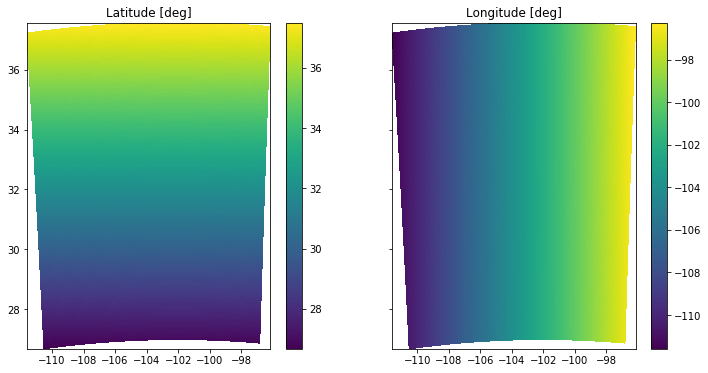

In [9]:
fig,ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12,6))
lat_cont = ax[0].pcolormesh(lon,lat,lat)
plt.colorbar(lat_cont,ax=ax[0])
ax[0].set_title('Latitude [deg]')
lon_cont = ax[1].pcolormesh(lon,lat,lon)
plt.colorbar(lon_cont,ax=ax[1])
ax[1].set_title('Longitude [deg]')
plt.show()

In [10]:
# Option A: Read in with netCDF4 (old way)
T_A = wrf_single.variables['T'][:] + 300.0 # Need to add 300 to get to full temp.

# Option B: Read in with wrf-python (good way)
T_B = getvar(wrf_single,'T') + 300.0 # Need to add 300 to get to full temp.

# Option C: Read in with wrf-python processed vars (best way)
T_C = getvar(wrf_single,'th') # Adds 300 for you!

if np.all(T_A==T_B) and np.all(T_A==T_C):
    print('Methods are the same!')

Methods are the same!


##### Other useful processed vars:

In [11]:
# u-, v-, and w-component wind on mass levels
u = getvar(wrf_single,'ua')
v = getvar(wrf_single,'va')
w = getvar(wrf_single,'wa')

# rotated winds
u_rotated, v_rotated     = getvar(wrf_single,'uvmet') # Also on mass levels
u10_rotated, v10_rotated = getvar(wrf_single,'uvmet10') # Also on mass levels
T2                    = getvar(wrf_single,'T2')

# Heights
z      = getvar(wrf_single,'z')
z_stag = getvar(wrf_single,'zstag')
z_agl  = getvar(wrf_single,'height_agl')

# Plotting

## Map plot:
### This was taken directly from:
https://wrf-python.readthedocs.io/en/latest/plot.html

### Currently, you cannot label any projections that aren't Mercator... maybe some day.

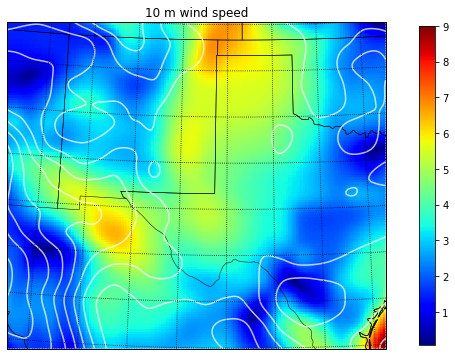

In [12]:
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature

from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)

# Get the latitude and longitude points
lats, lons = latlon_coords(u10_rotated)

# Get the cartopy mapping object
cart_proj = get_cartopy(u10_rotated)

# Create a figure
fig = plt.figure(figsize=(12,6))
# Set the GeoAxes to the projection used by WRF
ax = plt.axes(projection=cart_proj)

# Download and add the states and coastlines
states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=.5, edgecolor="black")
ax.coastlines('50m', linewidth=0.8)

# Make the contour outlines and filled contours for the smoothed sea level
# pressure.

wind_10m = (u10_rotated**2 + v10_rotated**2)**0.5

plt.pcolormesh(to_np(lons), to_np(lats), to_np(wind_10m),
             transform=crs.PlateCarree(),
             cmap=plt.cm.jet,
             rasterized=True)

# Add a color bar
plt.colorbar(ax=ax, shrink=.98)
plt.contour(to_np(lons), to_np(lats), to_np(T2), 10, colors='w',
            transform=crs.PlateCarree(), alpha=0.75)


# Set the map bounds
ax.set_xlim(cartopy_xlim(u10_rotated))
ax.set_ylim(cartopy_ylim(u10_rotated))

# Add the gridlines
ax.gridlines(color="black", linestyle="dotted",lw=0.5)

plt.title("10 m wind speed")

plt.show()


## Cross-section
#### Adapted from:
https://wrf-python.readthedocs.io/en/latest/plot.html

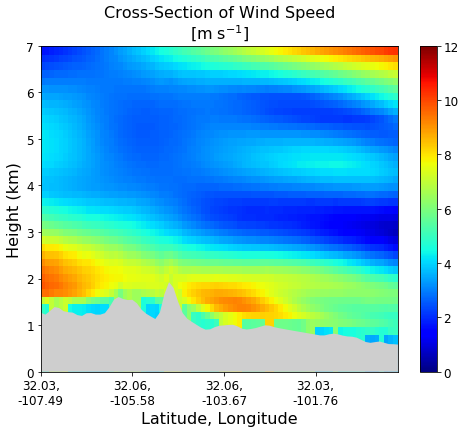

In [13]:
from cartopy.feature import NaturalEarthFeature
from netCDF4 import Dataset
from wrf import (getvar, to_np, get_cartopy, latlon_coords, vertcross,
                 cartopy_xlim, cartopy_ylim, interpline, CoordPair)
from matplotlib.colors import Normalize


# Define the cross section start and end points
cross_start = CoordPair(lat=32.0, lon=-107.5)
cross_end = CoordPair(lat=32.0, lon=-100)


# Get the WRF variables
ht = getvar(wrf_single, "z", timeidx=-1)
ter = getvar(wrf_single, "ter", timeidx=-1)


# Compute the vertical cross-section interpolation.  Also, include the
# lat/lon points along the cross-section in the metadata by setting latlon
# to True.
vel = (u**2 + v**2)**0.5
max_vel = 12.0 #np.max(u_cross_filled)

u_cross = vertcross(vel, ht, wrfin=wrf_single,
                    start_point=cross_start,
                    end_point=cross_end,
                    latlon=True, meta=True)

u_cross_filled = np.ma.copy(to_np(u_cross))


# For each cross section column, find the first index with non-missing
# values and copy these to the missing elements below.
for i in range(u_cross_filled.shape[-1]):
    column_vals = u_cross_filled[:,i]
    # Let's find the lowest index that isn't filled. The nonzero function
    # finds all unmasked values greater than 0. Since 0 is a valid value
    # for dBZ, let's change that threshold to be -200 dBZ instead.
    first_idx = int(np.transpose((column_vals > -200).nonzero())[0])
    u_cross_filled[0:first_idx, i] = u_cross_filled[first_idx, i]
    
# Get the terrain heights along the cross section line
ter_line = interpline(ter, wrfin=wrf_single, start_point=cross_start,
                      end_point=cross_end)

# Get the lat/lon points
lats, lons = latlon_coords(u)

# Get the cartopy projection object
cart_proj = get_cartopy(u)


# Create the figure
fig = plt.figure(figsize=(8,6))
ax_cross = plt.axes()


# Make the cross section plot for dbz
u_levels = np.arange(0.0,max_vel,0.5)
xs = np.arange(0, u_cross.shape[-1], 1)
ys = to_np(u_cross.coords["vertical"])/1000.0
u_contours = ax_cross.pcolormesh(xs,
                                 ys,
                                 to_np(u_cross_filled),
                                 cmap=plt.cm.jet,
                                 norm=Normalize(0,max_vel))
# Add the color bar
cb_u = fig.colorbar(u_contours, ax=ax_cross)
cb_u.ax.tick_params(labelsize=12)

# Fill in the mountain area
ht_fill = ax_cross.fill_between(xs, 0, to_np(ter_line)/1000.0,
                                facecolor="050")




# Set the x-ticks to use latitude and longitude labels
coord_pairs = to_np(u_cross.coords["xy_loc"])
x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str() for pair in to_np(coord_pairs)]
newx_labels = ['']*len(x_labels)
for xx,label in enumerate(x_labels): 
    lat_str,lon_str = label.split(',')
    lat_str = '{0:2.2f}'.format(float(lat_str))
    lon_str = '{0:2.2f}'.format(float(lon_str))
    new_label = '{},\n{}'.format(lat_str,lon_str)
    newx_labels[xx] = new_label


# Set the desired number of x ticks below
num_ticks = 4
thin = int((len(x_ticks) / num_ticks) + .5)
ax_cross.set_xticks(x_ticks[::thin])
ax_cross.set_xticklabels(newx_labels[::thin], rotation=0, fontsize=8)


ax_cross.set_ylim((0,7))
# Set the x-axis and  y-axis labels
ax_cross.set_xlabel("Latitude, Longitude", fontsize=16)
ax_cross.set_ylabel("Height (km)", fontsize=16)

# Add a title
ax_cross.set_title("Cross-Section of Wind Speed\n[m s$^{-1}$]", {"fontsize" : 16})
ax_cross.tick_params(labelsize=12)
plt.show()

### Time-height

In [14]:
from wrf import ALL_TIMES, ll_to_xy

# This is how you get data from all wrf files with wrf-python
u_rotated, v_rotated = getvar(wrf_multiple,'uvmet',timeidx=ALL_TIMES, method="cat") # Also on mass levels
times  = getvar(wrf_multiple,'Times',timeidx=ALL_TIMES, method="cat")
xtimes = getvar(wrf_multiple,'xtimes',timeidx=ALL_TIMES, method="cat")
height = getvar(wrf_multiple,'height',timeidx=ALL_TIMES, method="cat")

In [15]:
# Where do you want to look at the data?
point_of_interest = [33.4755, -102.2123] # lat,lon

# Use wrf-python's lat,long to x,y function:
poi_i, poi_j = ll_to_xy(wrf_multiple,point_of_interest[0],point_of_interest[1])

# Grab the velocity at this location:
vel_rotated = (u_rotated[:,:,poi_j,poi_i]**2 + v_rotated[:,:,poi_j,poi_i]**2)**0.5

In [16]:
# Generate your mesh (time x height)
tz,zt = np.meshgrid(times,height[0,:,poi_j,poi_i]/1000.0)

In [17]:
# We need to use pandas for this plotting method... not sure why
from pandas.plotting import register_matplotlib_converters

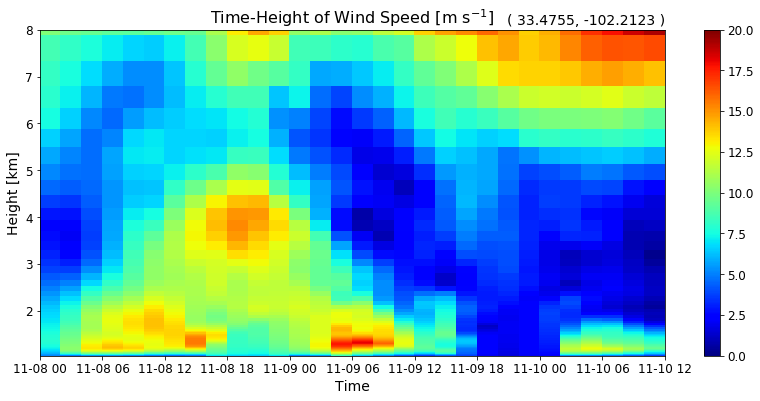

In [18]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(14,6))
register_matplotlib_converters()
# Plot velocity time-height
time_height = ax.pcolormesh(tz,zt,vel_rotated.T,cmap=plt.cm.jet,norm=Normalize(0,20))
# Add colorbar
cb_th = fig.colorbar(time_height, ax=ax)
cb_th.ax.tick_params(labelsize=12)
# Set various parameters
ax.tick_params(labelsize=12)
ax.set_xlabel('Time',size=14)
ax.set_ylabel('Height [km]',size=14)
ax.set_ylim(np.min(zt),8.0)
ax.set_title('Time-Height of Wind Speed [m s$^{-1}$]',size=16)
# Show the location of the time-height plot
ax.text(times[-1].data,8.04,'( {}, {} )'.format(point_of_interest[0],point_of_interest[1]),
        ha='right',va='bottom',size=14)
plt.show()

### Profiles using the same data

In [19]:
# Again, pandas is used here to help with the datetime plotting methods... maybe there is a better way
import pandas as pd

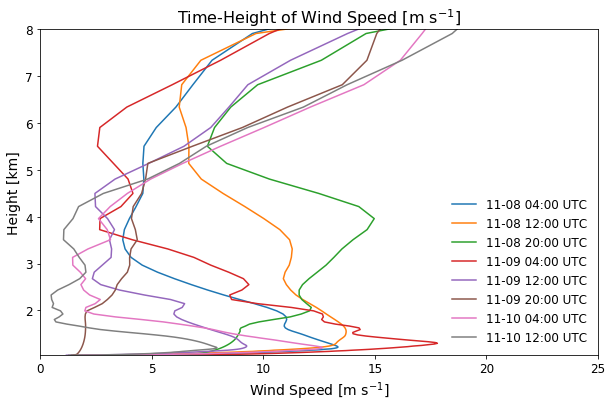

In [20]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,6))
# Loop over the times you want and plot each individually
for tt in range(2,times.size,4):
    plt_label = datetime.date.strftime(pd.to_datetime(times[tt].data),'%m-%d %H:%M UTC')
    ax.plot(vel_rotated[tt,:],height[0,:,poi_j,poi_i]/1000.0,label=plt_label)
# Turn on the legend but take away the frame
ax.legend(frameon=False,fontsize=12)
# Set various parameters
ax.tick_params(labelsize=12)
ax.set_xlabel('Wind Speed [m s$^{-1}$]',size=14)
ax.set_ylabel('Height [km]',size=14)
ax.set_ylim(np.min(zt),8.0)
ax.set_title('Time-Height of Wind Speed [m s$^{-1}$]',size=16)
ax.set_xlim(0,25)
plt.show()

### Time series with obs
For this, I'll read in the obs data with pandas and the tower data with the reader available on github: https://github.com/a2e-mmc/mmctools/tree/dev/wrf

### Get obs:

In [21]:
import wrf_tools.utils as wrftools
from datetime import timedelta  

In [22]:
# Read in the obs data with pandas
swift = pd.read_csv('/projects/mmc/SWIFTRegion/8Nov2013/TTU_20131108_10min.csv',parse_dates=True,index_col='datetime')

In [23]:
wrf_start_y = 2013
wrf_start_m = 11
wrf_start_d = 8
wrf_start_h = 0

wrf_start_date = pd.to_datetime(times[0].data)

towernum = 61
era_towerdir_d03 = '/scratch/phawbeck/WRF/SWIFT_2013110800/ERA/towers/'
era_tower_d03 = wrftools.Tower('{0}t{1:04d}.d03.*'.format(era_towerdir_d03,towernum))

#### Get times

In [24]:
nt_d03 = era_tower_d03.time.size
twr_date_d03 = ['']*nt_d03
for tt in range(0,nt_d03):
    twr_date_d03[tt] = wrf_start_date + timedelta(seconds=era_tower_d03.time[tt]*3600)

In [25]:
tower_z_d03 = 1.0*era_tower_d03.ph
tower_z_d03 = tower_z_d03 - float(era_tower_d03.stationz)
print("Lowest levels of d03: ", tower_z_d03[0,:5])

Lowest levels of d03:  [-1.207000e-02  4.842600e+00  9.627150e+00  1.448689e+01  1.927449e+01]


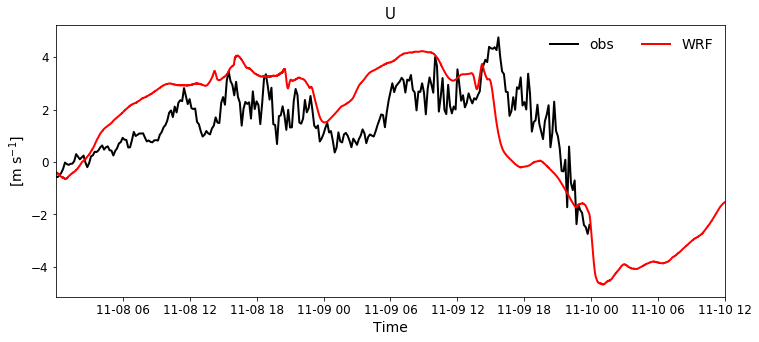

In [26]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,5))
ax.set_title('U',size=15)
ax.tick_params(labelsize=12)
ax.plot(swift.loc[swift['height']==10.1,'u'],label='obs',c='k',lw=2.0)
ax.plot(twr_date_d03,era_tower_d03.uu[:,2],label='WRF',c='red',lw=2.0)
ax.set_ylabel('[m s$^{-1}$]',size=14)
ax.set_xlabel('Time',size=14)
ax.legend(frameon=False,ncol=2,fontsize=14)
ax.set_xlim(twr_date_d03[0],twr_date_d03[-1])
plt.show()